# Notebook to explore tidal analysis by harmonics

We begin by importing the necessary modules and updating the plotting defaults.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quick_tidal_analysis.tidal_analysis import tidal_analysis
import matplotlib as mpl
mpl.style.use('bmh')

### Test 1: Simple combination of cosine waves

First we generate two cosine waves with period 1 and 0.5 days

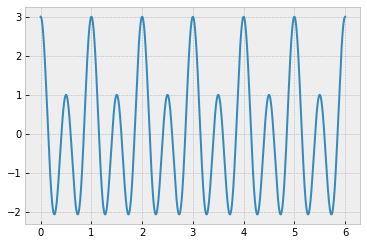

In [2]:
t = np.arange(0,6,0.001)
x = np.cos((2*np.pi*t)) + 2 * np.cos((2*np.pi*t)*2) 
plt.plot(t,x)

We pass these to the `tidal_analysis` function. Note the periods $T$ are specified in hours, though the timeseries $t$ is defined in yeardays

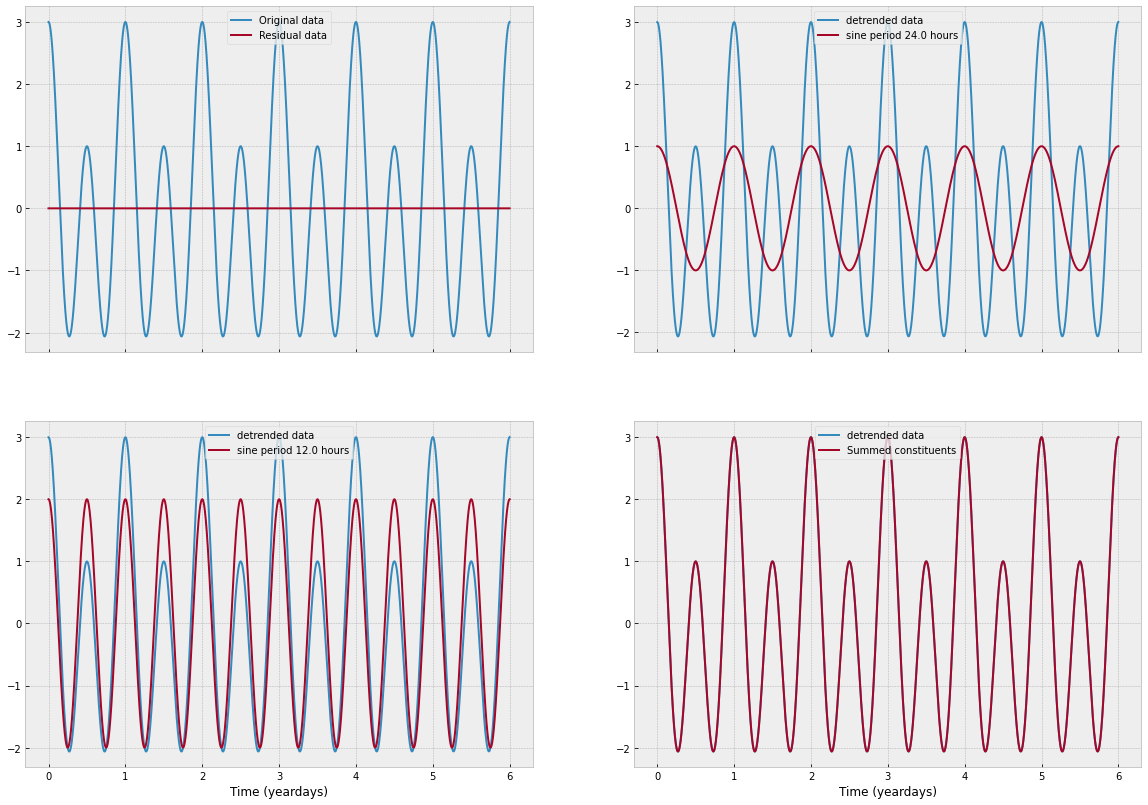

In [3]:
 df, df_consts, df_fine = tidal_analysis(x,t,T=[24,12],  plot_results=True)

From the top left plot, we can see that the detiding perfeclty removes the sine waves. We check df_consts for information on the sines

In [4]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,24,1.000000,24.0,0.000101,1.916378e-11
T2,12,1.999999,12.0,0.000050,2.134357e-12


As expected, the 12 hour signal has 2x the amplitide of the 24 hour signal, within mathematical accuracy. Phase and mean (offset) are both near 0

### Test 2: more complicated waves

Here we create cosines with period 8 and 24 hours, with differing amplitude and phase

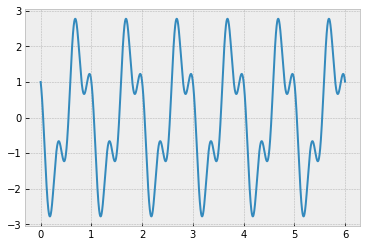

In [5]:
t = np.arange(0,6,0.001)
x = np.cos((2*np.pi*t)*3) + 2 * np.cos((2*np.pi*t)+np.pi/2)
plt.plot(t,x)

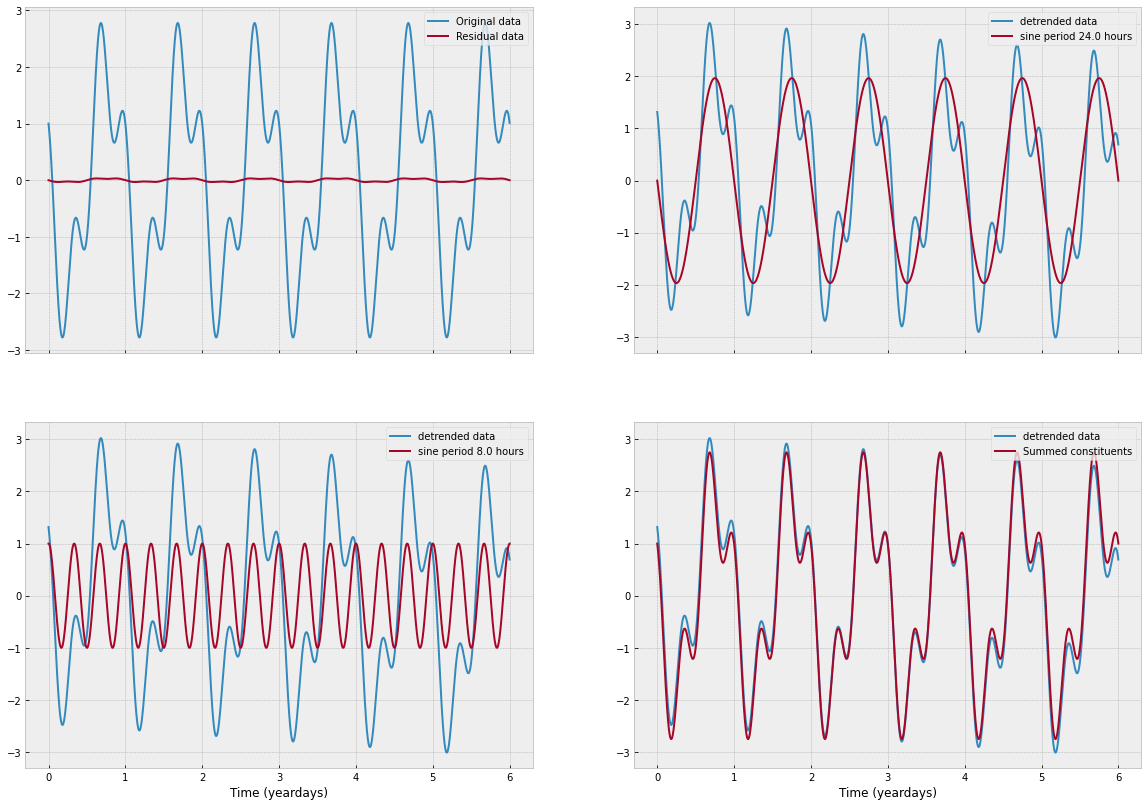

In [6]:
 df, df_consts, df_fine = tidal_analysis(x,t,T=[24,8], plot_results=True)

We have an unwanted residual. From the bottom right plot we can see the cause. Detrending of a short time period of observation has appplied an incorrect slope adjustment. We can run the function without detrending the input signal to correct this. To acheive this , we se the option `remove_trend=False`

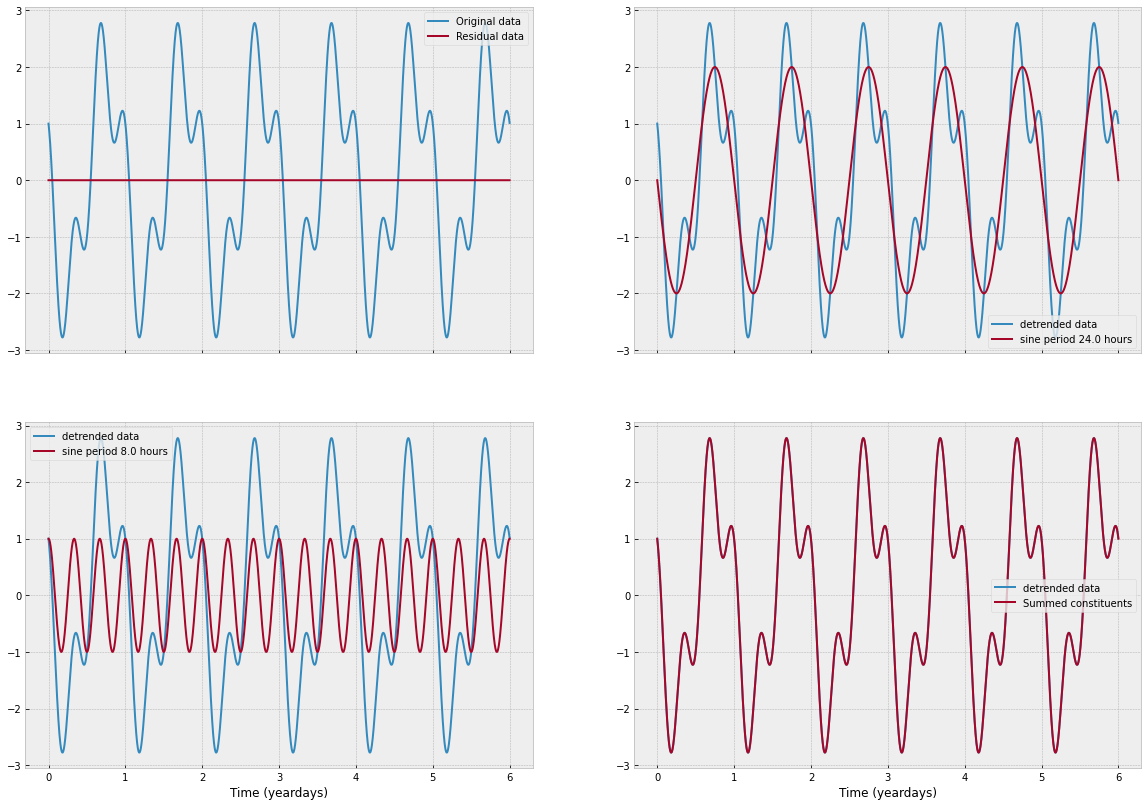

In [7]:
 df, df_consts, df_fine = tidal_analysis(x,t,T=[24,8], remove_trend=False, plot_results=True)

In [8]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,24,2.0,24.0,1.570796e+00,-1.023053e-07
T2,8,1.0,8.0,-1.988799e-10,-1.106008e-11


Much better. We see that there is a phase offset of $\frac{\pi}{2}$ between the two signals, as expected.

An alternative sloution is to use a longer timeseries. **With many cycles of the signal, trend correction has a negligible effect** on the subequent curve fitting. Accurate results cannot be reliably obitained from short time series.

Here we create the same waveform but with a timeseries 10 x as long.

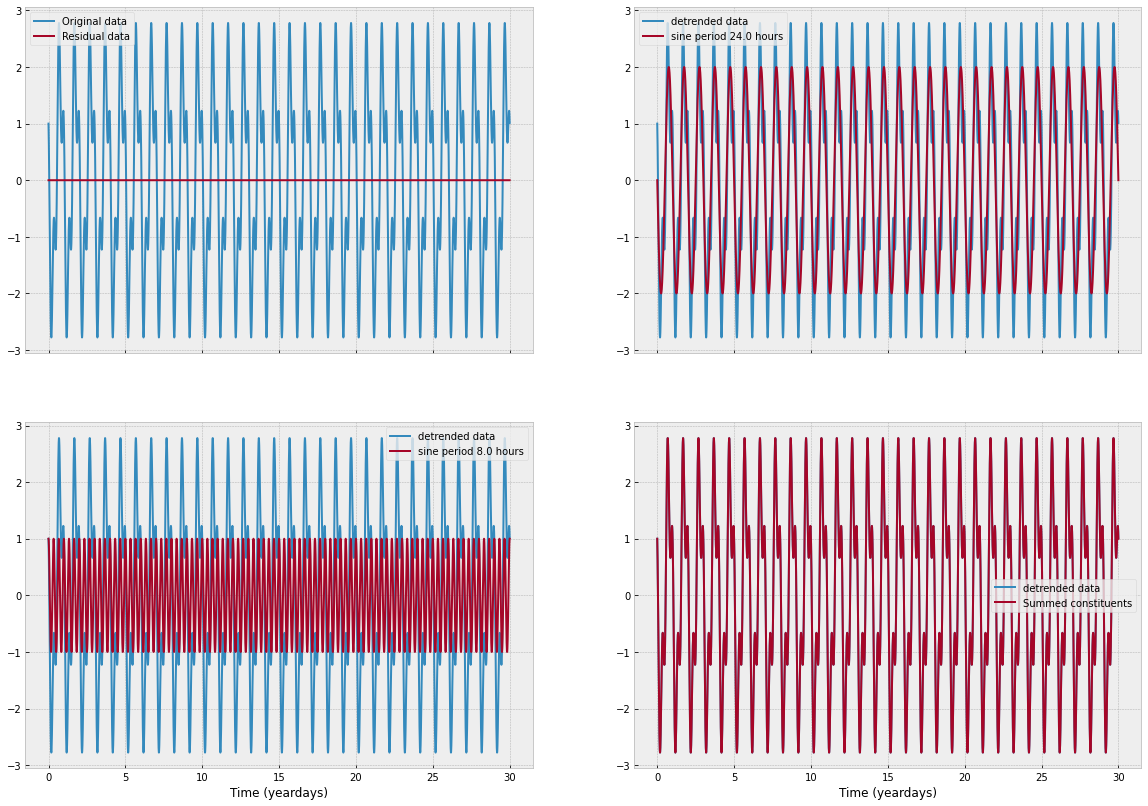

In [9]:
t = np.arange(0,30,0.001)
x = np.cos((2*np.pi*t)*3) + 2 * np.cos((2*np.pi*t)+np.pi/2)
df, df_consts, df_fine = tidal_analysis(x,t,T=[24,8], remove_trend=False, plot_results=True)

### Test 3: Add some noise and downsample the signal

Gaussian noise centered on 0 is applied to a more sparsely sampled sine wave

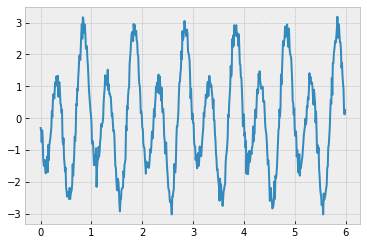

In [10]:
t = np.arange(0,6,0.01)
x = np.cos(t*2*np.pi+0.5) + 2 * np.cos(4*np.pi*t+np.pi-1) + 0.2*np.random.randn((len(t)))

plt.plot(t,x)

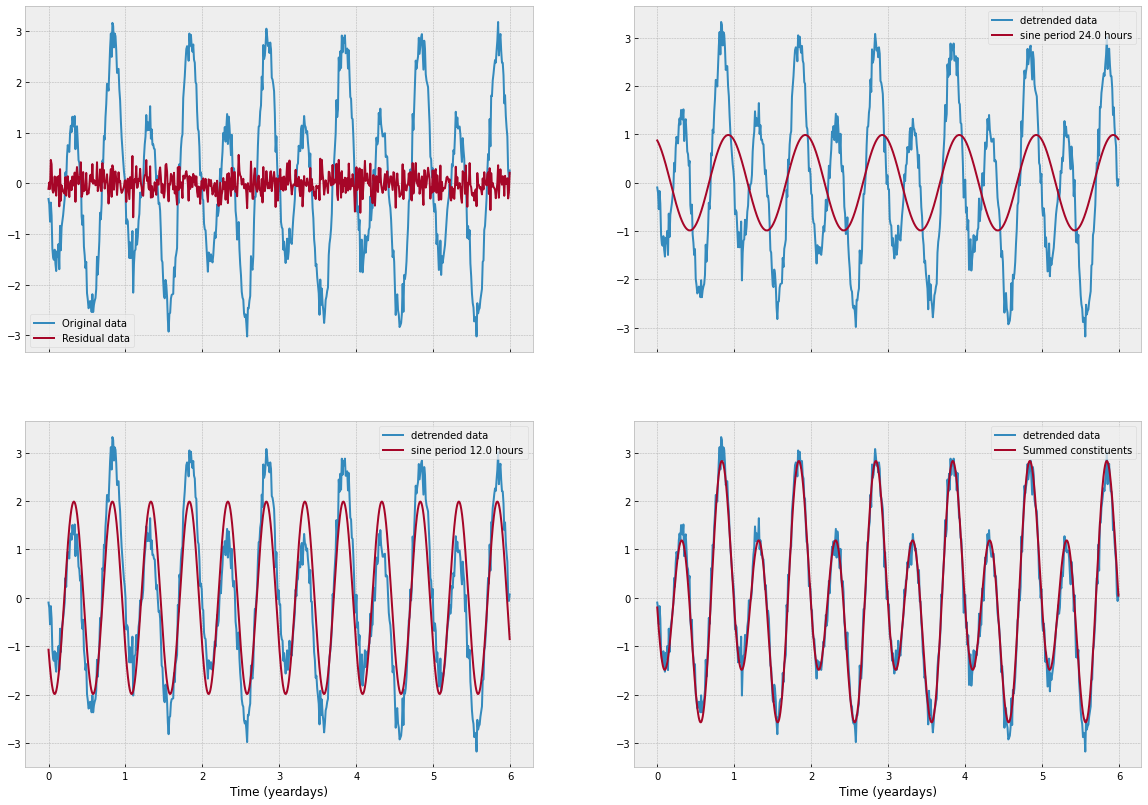

In [11]:
df, df_consts, df_fine = tidal_analysis(x,t,T=[24,12], plot_results=True)

In [12]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,24,0.986783,24.0,0.484497,-3.956730e-05
T2,12,1.988581,12.0,-1.001074,-7.292621e-08


White noise is left,  the amplitude estimate is not as accurate with an undersampled, noisy signal, but still is within 1 % of the signal we inpuit

### For an extra level of realism, we can randomly remove a portion of the observations

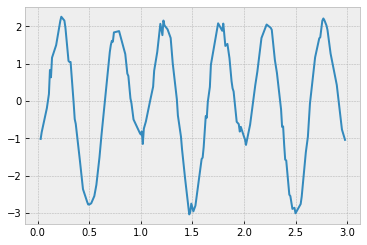

In [13]:
t = np.arange(0,3,0.01)
proportion_to_remove = 0.6
rand_num = np.random.rand(len(t))
t = t[rand_num > proportion_to_remove]
x = np.cos(t*2*np.pi) + 2 * np.cos(4*np.pi*t+np.pi) + 0.5*(np.random.rand((len(t)))-0.5) 
plt.plot(t,x)

To check the effects of the removal, we plot a histogram of sampling interval in hours (the original signal was sampled at a period of just over 15 minutes)

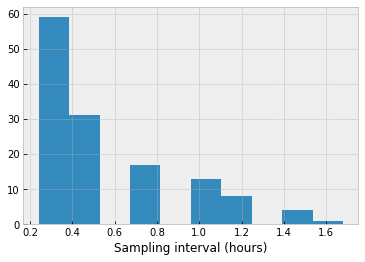

In [14]:
plt.hist(24*(t[1:] - t[:-1]))
plt.xlabel('Sampling interval (hours)');

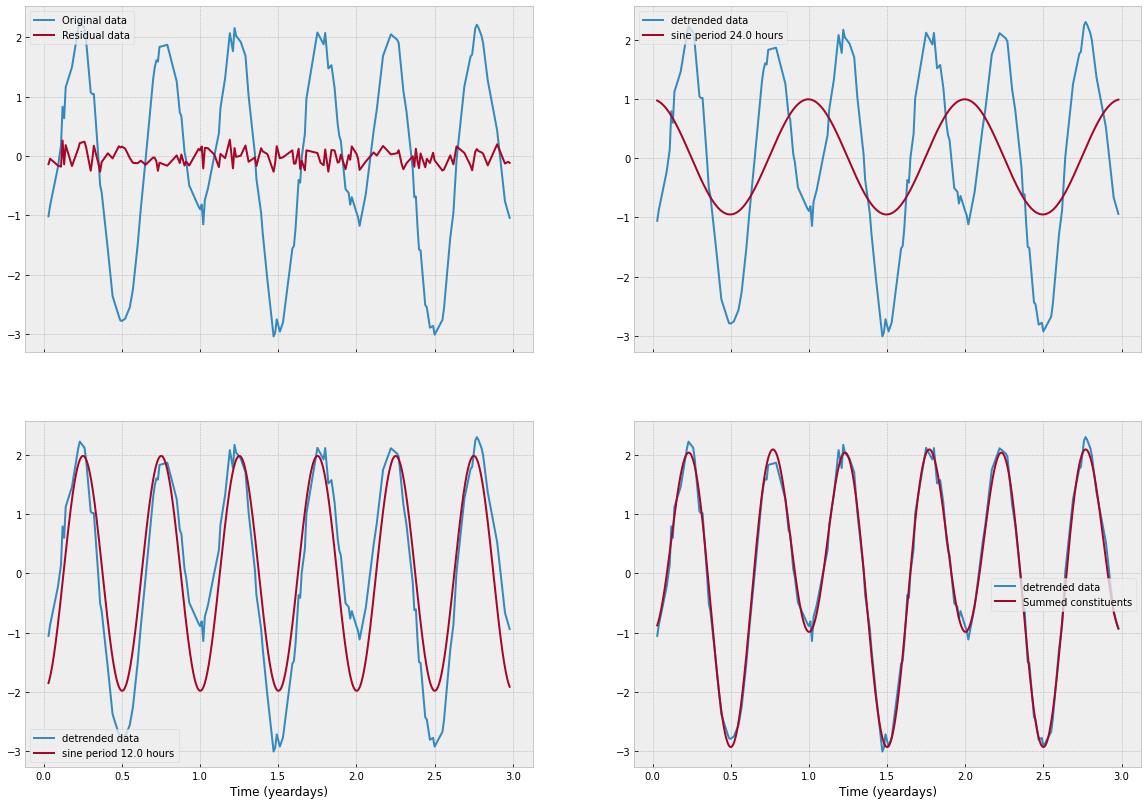

In [15]:
df, df_consts, df_fine = tidal_analysis(x,t,T=[24,12], plot_results=True)

In [16]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,24,0.972317,24.0,0.022120,0.022868
T2,12,1.983099,12.0,-0.011476,0.000019


### Test 4: Real data

Here I am importing a time series of conservative temperature at 200 m depth sampled by a Seaglider [(UEA glider group mission 60 EUREC4A: SG637)](http://ueaglider.uea.ac.uk/DIVES/index.php). This is irregularly sampled, noisy data.

In [17]:
df_omura = pd.read_csv("sample_data/omura_temp_200m.csv")
x = df_omura.temp_200m.values
t = df_omura.time_yday.values

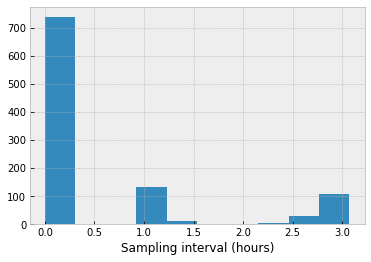

In [18]:
plt.hist(24*(t[1:] - t[:-1]))
plt.xlabel('Sampling interval (hours)');

Before we begin the tidal analysis, we plot the variable to see if there are any obvious sinusodal signals

[Text(0.5, 0, 'Time (yeardays of 2020)'),
 Text(0, 0.5, 'Conservative temperature at 200 m')]

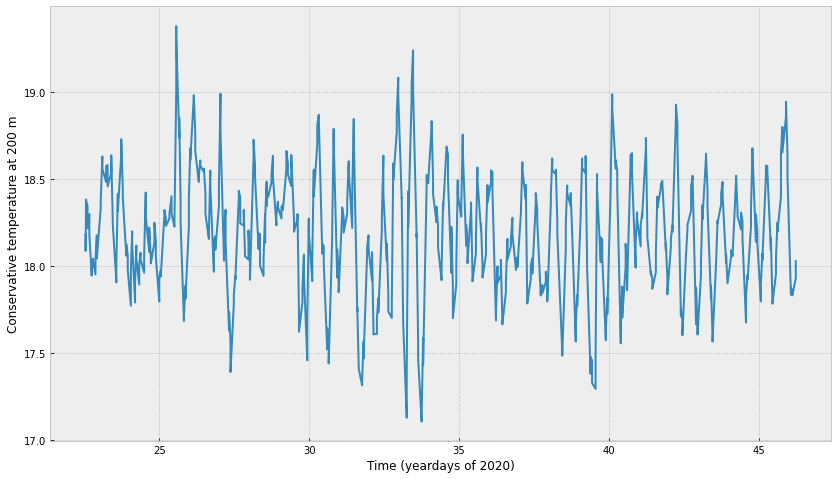

In [19]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(t, x)
ax.set(xlabel='Time (yeardays of 2020)', ylabel='Conservative temperature at 200 m')

There is a definitite semi-dirnal signal. Knowing that this is an open ocean time series, we look for tidal signals at 12.42 hours ($M_2$) and 23.93 hours ($K_1$)

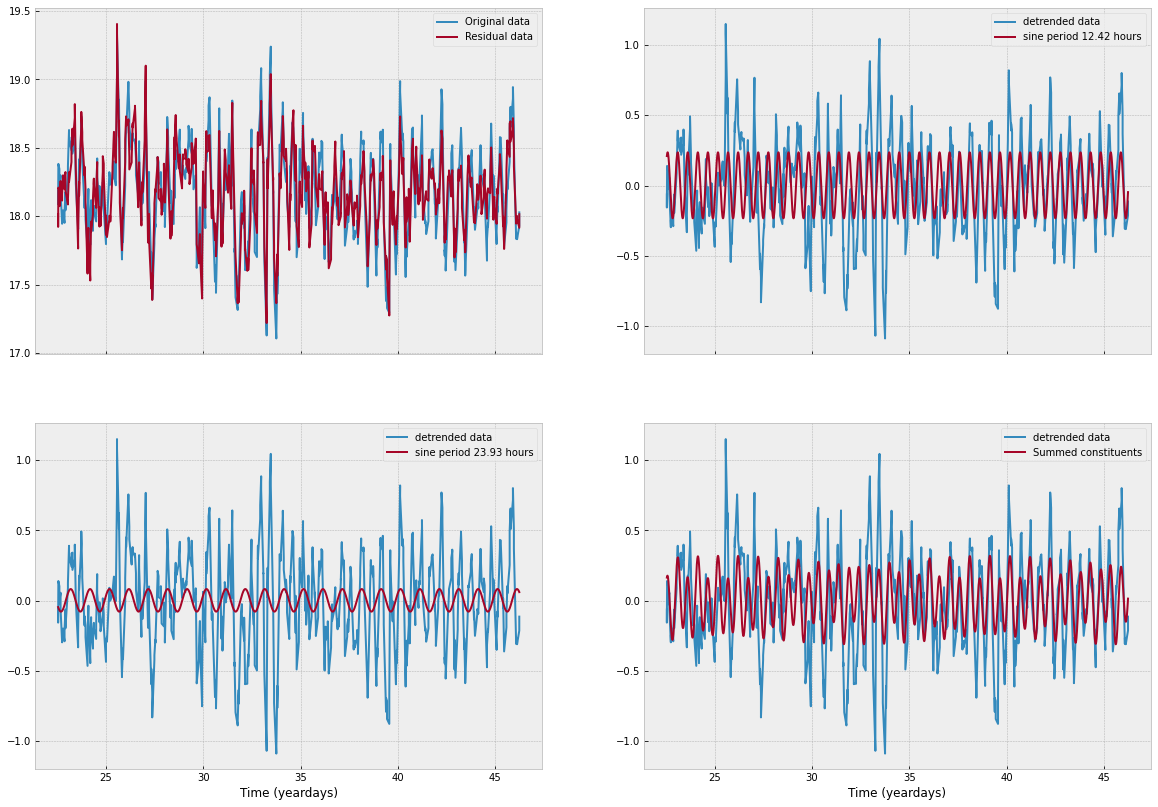

In [20]:
df, df_consts, df_fine = tidal_analysis(x, t, T=[12.42, 23.93], plot_results=True)

In [21]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,12.42,0.234623,12.42,-0.828132,0.001948
T2,23.93,0.080336,23.93,-1.591514,0.002638


In this case, the $M_2$ has an amplitude ~ 3x that of the $K_1$ and a phase offset of 0.5 radians (30 degrees)

------------------------------

### Experimental functionality

##### Can produce unanticipated or just plain wrong results. Use with extreme suspicion

For exploratory analysis, or a short/poorly sampled timeseries where adjacent frequency signals may be aliased into one (e.g. $M_2$ and $S_2$ measured over a timeseries of less than 14 days) `tidal_analysis` can seek in frequency space near to the user defined periods for the best fitting curves. We set ` freq_seek=True`

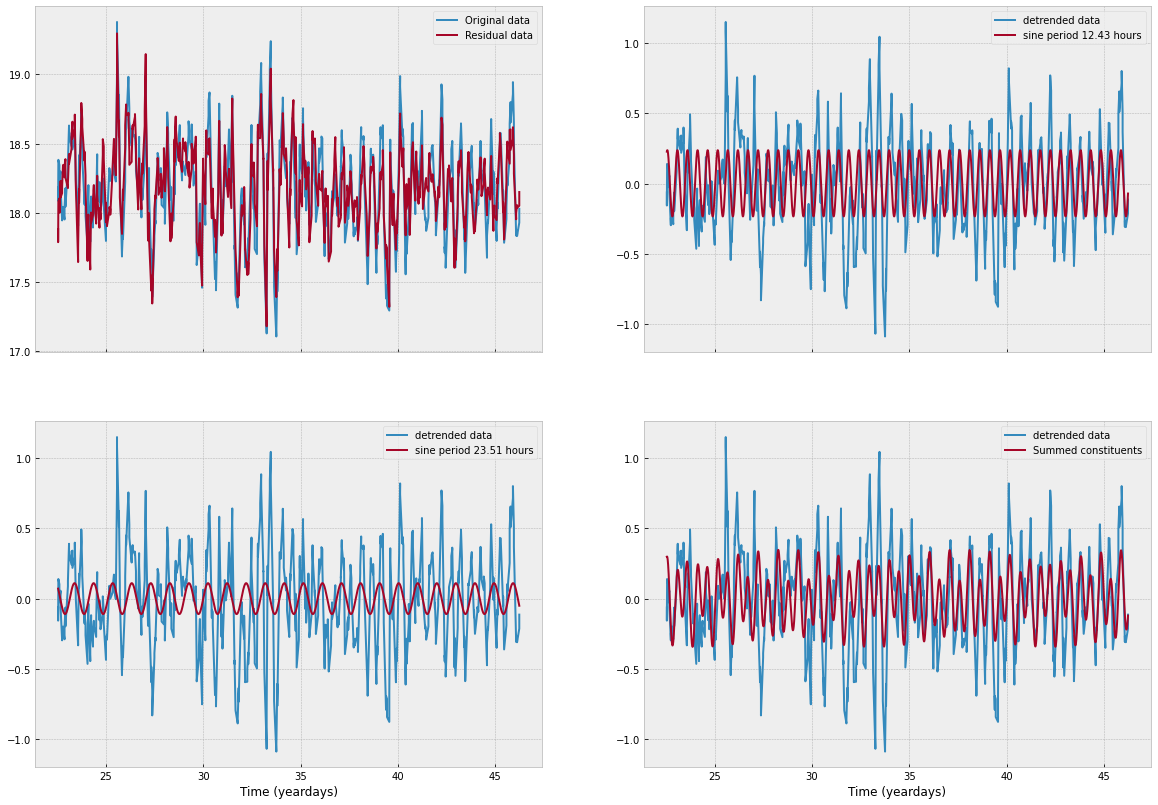

In [22]:
df, df_consts, df_fine = tidal_analysis(x,t,T=[12,24],  plot_results=True, freq_seek=True)

In [23]:
df_consts

,period_hours,amplitude,fitted_period_hours,phase,mean
const_id,,,,,
T1,12,0.235621,12.432576,-0.366795,0.002018
T2,24,0.109865,23.514050,0.833202,0.000632


With the frequency seeking functionality, a stronger near-diurnal sinusoid was found at 23.5 hours. This has an amplitude 25 % greater than the strict $K_1$ we previously specified

----------------------------
I hope you found this notebook useful. You can improve it on [github](https://github.com/callumrollo/quick_tidal_analysis).


Please direct any queries to Callum c.rollo@uea.ac.uk